Dataset source-link: https://www.kaggle.com/datasets/theovall/phonereviews?resource=download

An idea for pet-project: https://www.projectpro.io/article/nlp-projects-ideas-/452

Code source: https://towardsdatascience.com/unsupervised-sentiment-analysis-a38bf1906483

Firstly, i will aim to create an unsupervised classification due to lack of time. Data markup takes a lot of time considering amount of data i have is approximate to 200k rows. Apart from that my goal is to move this technique to different dataset in order to grow model and it's capabilities.

In [45]:
import pandas as pd
import multiprocessing
import re
import tempfile
import numpy as np
import spacy
import matplotlib.pyplot as plt

In [2]:
OMP_NUM_THREADS=1

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from gensim.models import Word2Vec
from time import time
from sklearn.cluster import KMeans
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import tokenize
from wordcloud import WordCloud

# Data Cleaning

In [4]:
data = pd.read_csv(r"C:\Users\Never Say\Desktop\Отзывы.csv")
data = data[['Review']]

In [5]:
data.head()

,Review
0,3D Touch просто восхитительная вещь! Заряд дер...
1,"Отключается при температуре близкой к нулю, не..."
2,"В Apple окончательно решили не заморачиваться,..."
3,Постарался наиболее ёмко и коротко описать все...
4,Достойный телефон. Пользоваться одно удовольст...


data = data.sample(n=7000)

In [6]:
df = data.copy()

*Let's remove that unnecessary \r (used to start from the new row) and all symbols including punctuation marks. Having numerical values also pointless because they might give us some noise in the data and it won't add much into model's data understanding. Regards English letters i deal the same way, they might get us some troubles*

In [7]:
df['Review'] = df['Review'].str.replace('\r', '', regex=True)
df['Review'] = df['Review'].str.lower()
df['Review'] = df['Review'].str.replace('[^а-я ]', '', regex=True)
df['Review'] = df['Review'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [8]:
print(f'The amount of dublicates is {df.duplicated().sum()} rows total')

df = df.drop_duplicates()

print(f'The lenght of data set is {len(df)} rows total')

The amount of dublicates is 169283 rows total
The lenght of data set is 289150 rows total


In [9]:
def nan_row_id(data, column):
    ids = list(data.loc[pd.isna(column), :].index)
    return ids

def remove_nan(data, column):
    nan = nan_row_id(data, column)
    data = data[~data.index.isin(nan)]
    return data

In [10]:
df = remove_nan(df, df['Review'])

print(f'Now lenght of data set is {len(df)} rows total')

Now lenght of data set is 289149 rows total


## Lemmatization

*For lemmatization i usually prefer using Spacy LLM model, it is fast, it is having Russian dictionary, and it is very easy in implementation. Very same Spacy model is used to remove stop words from dataset*

In [11]:
nlp = spacy.load("ru_core_news_sm")

spacy_stopwords = spacy.lang.ru.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))

Number of stop words: 768


In [12]:
def lemma(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = str(comment).lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in spacy_stopwords):
                lemmatized.append(lemma)
    return " ".join(lemmatized)

In [13]:
start = time()

dfn = df.copy()
dfn['Review_without_stopwords'] = df['Review'].apply(lemma, lowercase=False, remove_stopwords=True)

print('Time to clean the data: {} secs'.format(round((time() - start), 2)))

Time to clean the data: 10103.8 secs


In [14]:
dfn = remove_nan(dfn, dfn['Review_without_stopwords'])
dfn = dfn[['Review_without_stopwords']]
dfn = dfn[['Review_without_stopwords']].drop_duplicates()
len(dfn)

285456

In [15]:
pd.Series(' '.join(dfn['Review_without_stopwords']).lower().split()).value_counts()[:10]

телефон         300954
хороший          96947
экран            78458
аппарат          67899
камера           65608
купить           65424
год              63498
работать         63463
день             60757
пользоваться     51558
Name: count, dtype: int64

*Now i can see that dataset is all good and cleaned and ready to go into modeling stage*

dfn.to_csv(r"C:\Users\Тумукыфнину\Desktop\dfn.csv", index=False)

dfn = pd.read_csv(r"C:\Users\Тумукыфнину\Desktop\dfn.csv")

# Modeling

*Here i look for most frequent bigrams of words and replace them with gensim’s Phrases module*

dfn = dfn[dfn['Review_without_stopwords'].str.len()>1]

*After that simpliest tokenization using gensim.utils.tokenize*

In [16]:
tokens = []

for i in dfn['Review_without_stopwords']:
    tokens.append(list(tokenize(i)))

In [17]:
tokens

[['восхитительный',
  'вещь',
  'заряд',
  'держать',
  'целый',
  'день',
  'розовый',
  'цвет',
  'смотреться',
  'необычно',
  'быстрый',
  'удобный',
  'советовать',
  'телефон'],
 ['отключаться',
  'температура',
  'близкий',
  'нуль',
  'непонятно',
  'вести',
  'батарея'],
 ['окончательно',
  'решить',
  'заморачиваться',
  'делать',
  'незначительный',
  'изменение',
  'телефон',
  'выдавать',
  'изменение',
  'инновация',
  'раз',
  'скопировали',
  'функционал',
  'дизайн',
  'цена',
  'неадекватно',
  'завысить',
  'скачок',
  'курс',
  'говорить',
  'приходиться',
  'сказать',
  'разрешение',
  'достаточный',
  'диагональ',
  'аппарат',
  'позиционироваться',
  'топовый',
  'решение',
  'итог',
  'получать',
  'банальный',
  'экономия',
  'производитель',
  'произойдт',
  'время',
  'работа',
  'увеличить',
  'гб',
  'оперативка',
  'прошлый',
  'век',
  'рассказывать',
  'сказка',
  'великолепный',
  'оптимизация',
  'чудо',
  'свет',
  'бывать',
  'сказать',
  'волновать'

*And here i create vocabulary from tokens i created before*

*- min_count = 3 - remove most unusual words from training embeddings, like words 'ssssuuuuuuuppppppeeeeeerrrr', which   actually stands for 'super', and doesn't need additional training*

*- window = 4 - Word2Vec model will learn to predict given word from up to 4 words to the left, and up to 4 words to     the right*

*- vector_size = 300 - size of hidden layer used to predict surroundings of embedded word, which also stands for         dimensions of trained embeddings*

*- sample = 1e-5 - probability baseline for subsampling most frequent words from surrounding of embedded word*
  
*- negative = 20 - number of negative (ones that shouldn't have been predicted while modeling selected pair of words) words that will have their corresponding weights updated while training on specific training example, along with positive word*

In [18]:
w2v_model = Word2Vec(min_count=3,
                     window=7,
                     vector_size=400,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=multiprocessing.cpu_count()-1)

start = time()

w2v_model.build_vocab(tokens, progress_per=50000)

In [19]:
w2v_model.train(dfn, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(0, 720)

In [20]:
with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
    temporary_filepath = tmp.name
    w2v_model.save(r"C:\Users\Never Say\Desktop\word2vec.model")

In [21]:
word_vectors = Word2Vec.load(r"C:\Users\Never Say\Desktop\word2vec.model").wv

In [22]:
model = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors.astype('double'))

In [23]:
word_vectors.similar_by_vector(model.cluster_centers_[1], topn=10, restrict_vocab=None)

[('день', 0.29386022686958313),
 ('нужн', 0.19784313440322876),
 ('сдвигается', 0.1922995001077652),
 ('даб', 0.18876127898693085),
 ('разряжала', 0.1871597170829773),
 ('горилаглас', 0.18453702330589294),
 ('бренда', 0.18449001014232635),
 ('телефонсо', 0.1829090416431427),
 ('модел', 0.18129760026931763),
 ('обажаю', 0.18125101923942566)]

In [24]:
positive_cluster_index = 1
positive_cluster_center = model.cluster_centers_[positive_cluster_index]
negative_cluster_center = model.cluster_centers_[1-positive_cluster_index]

In [25]:
words = pd.DataFrame(word_vectors.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

words['cluster_value'] = [1 if i==positive_cluster_index else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

In [26]:
words[['words', 'sentiment_coeff']].to_csv(r"C:\Users\Never Say\Desktop\sentiment_dictionary.csv", index=False)

In [27]:
sentiment_map = pd.read_csv(r"C:\Users\Never Say\Desktop\sentiment_dictionary.csv")
sentiment_dict = dict(zip(sentiment_map.words.values, sentiment_map.sentiment_coeff.values))

*This is the place where i had most fun*

dfn = pd.read_csv(r"C:\Users\Never say\Desktop\dfn.csv")
words = pd.read_csv(r"C:\Users\Never say\Desktop\sentiment_dictionary.csv")

In [31]:
dfn = remove_nan(dfn, dfn['Review_without_stopwords'])

In [32]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None)
tfidf_matrix = tfidf_vectorizer.fit_transform(dfn['Review_without_stopwords'])

def create_tfidf_dictionary(tfidf_matrix, feature_names):
    tfidf_dict = {}
    for i in range(tfidf_matrix.shape[0]):
        feature_index = tfidf_matrix[i, :].nonzero()[1]
        tfidf_scores = zip(feature_index, [tfidf_matrix[i, x] for x in feature_index])
        tfidf_dict[i] = {feature_names[x]: score for x, score in tfidf_scores}
    return tfidf_dict

def replace_words_with_tfidf(sentence, tfidf_dict):
    words = sentence.split()
    replaced_words = []
    for word in words:
        for doc_index, doc_tfidf_dict in tfidf_dict.items():
            if word in doc_tfidf_dict:
                replaced_words.append(doc_tfidf_dict[word])
                break
    return replaced_words

tfidf_dict = create_tfidf_dictionary(tfidf_matrix, tfidf_vectorizer.get_feature_names_out())

dfn['TF-IDF'] = dfn['Review_without_stopwords'].apply(lambda x: replace_words_with_tfidf(x, tfidf_dict))

C:\Users\Never say\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(dfn['Review_without_stopwords'])

def create_tfidf_dictionary(tfidf_matrix, feature_names):
    tfidf_dict = {}
    for i in range(tfidf_matrix.shape[0]):
        feature_index = tfidf_matrix[i,:].nonzero()[1]
        tfidf_scores = zip(feature_index, [tfidf_matrix[i, x] for x in feature_index])
        tfidf_dict[i] = {feature_names[i]: score for i, score in tfidf_scores}
    return tfidf_dict

def replace_words_with_tfidf(sentence, tfidf_dict):
    words = sentence.split()
    replaced_words = []
    for word in words:
        for doc_index, doc_tfidf_dict in tfidf_dict.items():
            if word in doc_tfidf_dict:
                replaced_words.append(doc_tfidf_dict[word])
                break
    return replaced_words

'''
creating TF-IDF dictionary for each row
'''
tfidf_dict = create_tfidf_dictionary(tfidf_matrix, tfidf_vectorizer.get_feature_names_out())
'''
replacing words in dataframe with TF-IDF values
'''
dfn['TF-IDF'] = dfn['Review_without_stopwords'].apply(lambda x: replace_words_with_tfidf(x, tfidf_dict))

In [33]:
replaced_tfidf_scores = dfn[['TF-IDF']].copy()

In [34]:
def replace_sentiment_words(word, sentiment_dict):
    '''
    replacing each word with its associated sentiment score from sentiment dict
    '''
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [35]:
replaced_closeness_scores = dfn['Review_without_stopwords'].apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split())))
replaced_closeness_scores = pd.DataFrame(data=replaced_closeness_scores)
replaced_closeness_scores = replaced_closeness_scores.rename(columns={'Review_without_stopwords': 'sentiment_coeff',})

*Merging TF-IDF and Closeness score*

In [36]:
replacement_df = pd.DataFrame(data=[replaced_closeness_scores['sentiment_coeff'], replaced_tfidf_scores['TF-IDF'], dfn['Review_without_stopwords']]).T
replacement_df.columns = ['sentiment_coeff', 'tfidf_scores', 'sentence']

replacement_df['sentiment_rate'] = replacement_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
replacement_df['prediction'] = (replacement_df.sentiment_rate>0).astype('int8')

*If the dot product was positive, the sentiment was positive, and in opposite case negative. So 1 = Positive and 0 = Negative*

In [37]:
replacement_df

,sentiment_coeff,tfidf_scores,sentence,sentiment_rate,prediction
0,"[35.11017700512685, -34.575629943649105, -35.1...","[8.889017849313305, 5.018401121214908, 4.21758...",восхитительный вещь заряд держать целый день р...,565.804553,1
1,"[-34.58200506637689, -33.61077099971194, -34.5...","[6.302730555678111, 7.148387726607854, 5.74987...",отключаться температура близкий нуль непонятно...,-781.730097,0
2,"[-34.2584305496033, -34.39914321328319, 33.313...","[6.845251910254233, 4.188367574421848, 7.45037...",окончательно решить заморачиваться делать незн...,-149.434488,0
3,"[-35.11799684606422, -33.096843280619005, 33.0...","[7.062059643119357, 12.17555232265532, 8.17735...",постараться мко коротко описать основный плюс ...,770.081170,1
4,"[-34.9030384513013, -34.925228974234486, -35.5...","[4.575024933443322, 1.593029191503896, 2.86434...",достойный телефон пользоваться удовольствие,-127.370272,0
...,...,...,...,...,...
458427,"[34.83379864449266, 34.2710166819414, -35.1934...","[4.2753789514114775, 4.839429542347715, 5.3569...",сеть ловить норма самсунг гэлэкси гио разница ...,-78.333519,0
458428,"[34.94960133118175, 34.771950261193425, -34.27...","[3.399539603472404, 3.48134329156866, 5.535100...",удобный вс работать отлично звонить играть сни...,178.240207,1
458429,"[34.57658464728644, -34.39963654662623, -35.54...","[5.1654661125757215, 2.7562484629387622, 8.408...",пройти год притензий нагрузка звонок день час ...,-72.277425,0
458430,"[-34.3578711828342, 33.37238230856797, -33.883...","[6.731155166485207, 2.7665250397989194, 7.5816...",первый аппарат андроид момент разачарован шуст...,-1286.884349,0


In [38]:
result = pd.merge(data, replacement_df['prediction'], left_index=True, right_index=True)

In [39]:
with pd.option_context("display.max_colwidth", None):
    display(result)

,Review,prediction
0,3D Touch просто восхитительная вещь! Заряд держит целый день. В розовом цвете смотрится очень необычно. Touch ID очень быстрый и удобный. Всем советую этот телефон!,1
1,"Отключается при температуре близкой к нулю, непонятно ведет себя батарея",0
2,"В Apple окончательно решили не заморачиваться, делая незначительные изменения в телефоне, выдают эти изменения за инновации. На этот раз скопировали не только функционал, но и дизайн. Цена и была неадекватно завышена, а после скачка курса так и говорить об этом не приходится. Многие скажут, что и HD разрешения будет достаточно для такой диагонали, может так оно и есть, но аппарат позиционируется, как топовое решение, а в итоге получаем банальную экономию производителя, ведь что произойдёт с временем работы, если увеличить до FHD?! 1 гб оперативки тоже прошлый век! И не надо рассказывать сказки про великолепную оптимизацию iOS, чудес на свете не бывает, этого мало. Те кто скажет, что их не волнуют технические характеристики смартфона, главное чтоб он хорошо работал, телефон за 5000 будет так же хорошо работать, а отдавая (выбрасывая) 55000 нужно думать головой и понимать, что этих денег данный телефон просто непросто не может стоить! Про удобство использования стоит отметить, что больший по размерам Note 4 гораздо лучше лежит в руке и пользоваться им сподручнее.",0
3,"Постарался наиболее ёмко и коротко описать все основные плюсы и минусы. Большим мне аппарат не показался, размеры - что надо. Внешний вид, как для меня, так 5-ка выглядит интереснее и солиднее.",1
4,Достойный телефон. Пользоваться одно удовольствие.,0
...,...,...
458427,"сеть ловит норм, до этого был самсунг гэлэкси гио, разницы не заметил, даже может лучше",0
458428,"удобный, всё работает отлично, звонит, играет, снимает, ловит, прочный, вообщем за 5 т. руб. лучше не найдёшь))",1
458429,"прошло больше года, притензий нет, при моей нагрузке 50-60 звонков в день около 1,5 часов разговоров, изредка пробки, инет очень редко, заряда хватает от 5 до 7 дней...а тем кого что-то неустраивает предлогаю просто взять деньги и пойти до магазина (благо их немеряно) и купить другой смартфон...",0
458430,"мой первый аппарат на андроиде. На данный момент не разачарован - шустрый аппарат и чистая система из коробки - никаких тупых навязаных приложений, что тебе нужно - то и поставь. Супер внешний вид - стильно и строго, упаковка также выглядит богато. В режиме 0,5 часа wi-fi, 1 час разговоров, 1 час радио/мр3 продержался 4 дня.P. s По итогам годового использования - впечатления лишь положительные. батарея держит по 3-4 дня, царапин не появилось (правда юзаю его в чехле), система - ни одного слета и зависания! Супер аппарат! скорее всего отдам супруге, ибо сам уже облизываюсь на HONPhone W33.",0


# Retrieving Results

In [43]:
with pd.option_context("display.max_colwidth", None):
    display(result.sample(n=7))

,Review,prediction
266466,"Модель Microsoft Lumia 435 Dual Sim, впечатляет своей скоростью работы по сравнению с телефоном SONY Xperia Sola(После установки туда обновлений Google+ и Hangouts) и что немало важно практический никогда за время использования не зависал, хотя и несколько раз уходил в перезагрузку по причинам связанным с установленной на этот телефон Windows 10 Mobile Technical/Insider Preview, сам я брал этот телефон для тестирования этой самой системы, потом система прижилась и я начал через 2 месяца активно использовать новую ОС и этот аппарат, основные проблемы которые были замечены к дню написания отзыва это отваливается адаптер беспроводной сети(Wi-Fi) спустя 72 часа работы, не поднимается мобильная связь(Проблема уже решена в последнем обновлении для участников программы Windows Insider) из положительного было замечено прирост производительности после обновления телефона с стандартной(заводской) прошивки на прошивку для участников программы Windows Insider, замена браузера по умолчанию с Microsoft Internet Explorer на Microsoft Edge.",1
456522,отличная модель для людей без интернета. Взял отцу только для связи. Он полностью доволен.,1
108989,"Использую телефон с 31 января, перешел с Nokia E72, сразу приобрел защитную пленку, чехол и автозарядку и проблем не знаю... Не царапается, батарея всегда в порядке, функций хватает не только на этот телефон, а еще и поделиться можно... Так что при таком арсенале цена у него абсолютно нормальная. Сразу скажу, сравнивал и выбирал между Apple iPhone 4 и HTC Desire HD... Но в Apple функции те же, а цена на 10 000 выше, так что переплачивать за бренд и привязываться к iTunes не хотелось. Подводя итог скажу, решать все равно вам, но этот телефон - лучший аппарат в своей категории!!! Я очень им доволен и не поменяю его ни на какой другой!!!",1
211683,"мне подарили на 8 марта,сейчас прошло полтора года,живой,старый но живой! Отличный телефон,советую!",0
158200,"телефончик среднего уровня: свое дело делает (звонит), не глючит, неплохо справляется с интернетом. в общем, денег своих стоит, но почему-то хочется уже другой).",1
64382,"В целом за свои деньги модель неплохая, да нет такого дисплея как у Самсунгов, но больше всего недостает того, что я описал в недостатках.",1
61981,"Начал пользоваться линейкой Galaxy с первой модели: Galaxy S, Galaxy S3, Galaxy S5. У всех них была одна общая и большая проблема, после которой я зарекся покупать Samsung - пропадала связь и не восстанавливалась, если не перезагрузить телефон.\rОднако, прочитав почти все обзоры на SGS 7 Edge, решил, что рискну еще раз. Не прогадал. Никаких потерей связи не наблюдаю. Телефоном доволен чуть больше чем полностью.",0


In [51]:
negative = replacement_df[replacement_df['prediction'] == 0][['sentence']]

In [55]:
result['prediction'].value_counts()

prediction
1    148932
0    136524
Name: count, dtype: int64

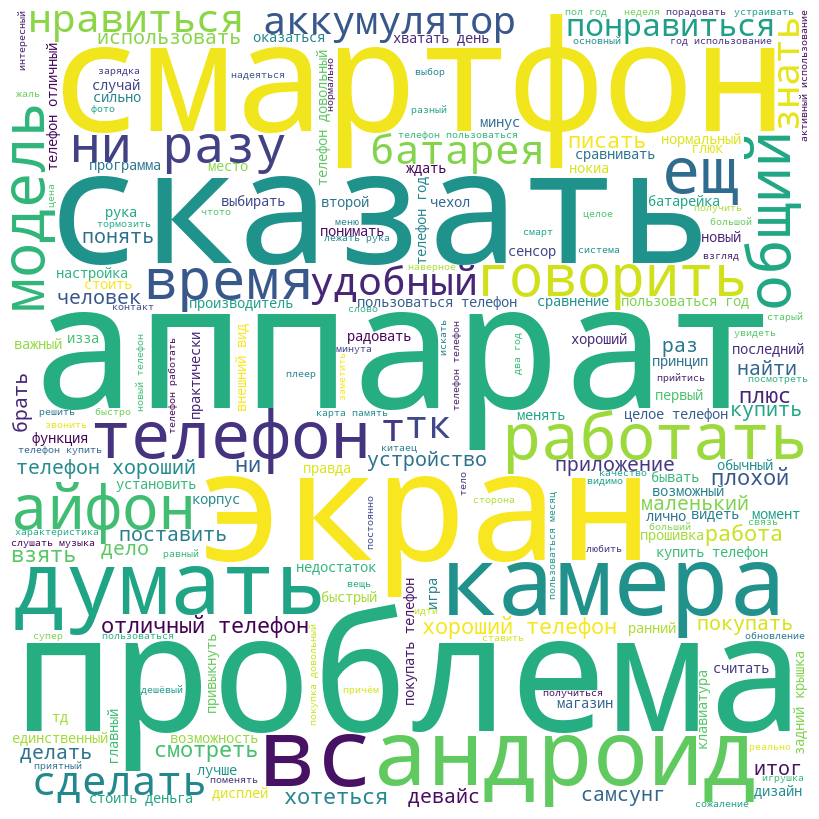

In [53]:
comment_words = ''

for val in negative['sentence']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

*I would say that the approach i took from the internet as a base isn't that good as they say. Mostly because algorithm can't decide which words have the negative sentiment and which are the positive and after all that the k-means splits them into two messy groups of mixed sentiments. Still, this is good research and it might be helpful in the future.*